# Classification with Inception-ResNet-v2 CNN architecture

Based on paper "Inception-ResNet-V2 Based Skin Lesion Classification for Early Detection and Treatment" https://www.computer.org/csdl/proceedings-article/ciisca/2023/397200a143/1U1rWxUTxfO

Code implementation based on https://huggingface.co/docs/timm/models/inception-resnet-v2.

In [35]:
import matplotlib.pyplot as plt
import numpy as np 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
from PIL import Image
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import classification_report
from tqdm import tqdm
import timm

Versions:
* python: 3.10
* pytorch-cuda: 11.8

In [7]:
print(torch.__version__)
print(torchvision.__version__)

2.3.0
0.18.0


## Training and evaluating the model

As the model training was slow, a .py was created based on the pipeline below to keep it running on the GPU even with terminal disconnections. After training, models were saved to .pth files and metrics (loss, accuracy) were saved to a .txt file.

In [8]:
file_path = 'metadata/metadataTrain.csv'

metadata_train = pd.read_csv(file_path)
metadata_train['CLASS'] -= 1

metadata_train.head()

,ID,CLASS,SEX,AGE,POSITION
0,ISIC_0028766,1,male,30.0,NaN
1,ISIC_0071222,7,male,85.0,lower extremity
2,ISIC_0069434,2,male,85.0,head/neck
3,ISIC_0062098,0,male,55.0,head/neck
4,ISIC_0057224,7,female,45.0,lower extremity


In [9]:
class CustomDataset(Dataset):
    def __init__(self, root, metadata, train, num_channels, transform=None):
        self.metadata = metadata
        self.root = root
        self.train = train
        self.transform = transform
        self.num_channels = num_channels

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, index):
        image_filename = self.metadata["ID"][index]

        image = Image.open(
            os.path.join(self.root, image_filename + ".jpg"), formats=["JPEG"]
        ).convert("RGB")

        if self.transform:
            image = self.transform(image)

        image = image[:self.num_channels]

        if self.train:
            label = self.metadata["CLASS"][index]
            return image, label

        return image

In [10]:
train_dir = 'Train'
metadata_file = 'metadata/metadataTest.csv'

img_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the dataset
train_data = CustomDataset(train_dir, metadata_train, train=True, num_channels=3, transform=img_transform)

# separate into train and validation
train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_data, [train_size, val_size], generator=torch.Generator().manual_seed(0))

In [11]:
# check GPU to work
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
print(device)

cuda


In [12]:
#model imported from timm library
model = timm.create_model('inception_resnet_v2', pretrained=False, num_classes=8)
model

InceptionResnetV2(
  (conv2d_1a): ConvNormAct(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNormAct2d(
      32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): ReLU(inplace=True)
    )
  )
  (conv2d_2a): ConvNormAct(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNormAct2d(
      32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): ReLU(inplace=True)
    )
  )
  (conv2d_2b): ConvNormAct(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNormAct2d(
      64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): ReLU(inplace=True)
    )
  )
  (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3b): ConvNormAct(
    (conv): Conv2d(64, 80, kernel_size=(1, 

In [34]:
learning_rate = 0.0001
num_epochs = 20
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=torch.Generator().manual_seed(0), num_workers=os.cpu_count())
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=os.cpu_count())

In [ ]:
# train model
model.to(device)
class_weights = [0.7005531, 0.24592265, 0.95261733, 3.64804147, 1.20674543, 13.19375, 12.56547619, 5.04219745]
criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float32).to(device))
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

# Initialize lists to store training and validation metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_accuracy = 0.0  # Initialize best validation accuracy

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    epoch_train_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training phase with tqdm progress bar
    with tqdm(train_loader, desc=f'Train Epoch {epoch + 1}/{num_epochs}', unit='batch') as train_tqdm:
        for images, labels in train_tqdm:
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            train_loss = criterion(outputs, labels)
            train_loss.backward()
            optimizer.step()
            epoch_train_loss += train_loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            train_tqdm.set_postfix({'train_loss': train_loss.item(), 'train_accuracy': 100 * correct_train / total_train})
    
    # Calculate average training loss and accuracy for the epoch
    avg_train_loss = epoch_train_loss / len(train_loader)
    avg_train_accuracy = 100 * correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_accuracy)

    # Validation phase
    model.eval()  # Set model to evaluation mode
    epoch_val_loss = 0.0
    correct_val = 0
    total_val = 0

    # Disable gradients during validation
    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images = val_images.to(device)
            val_labels = val_labels.to(device)
            val_outputs = model(val_images)
            val_loss = criterion(val_outputs, val_labels)
            epoch_val_loss += val_loss.item()

            # Calculate accuracy
            _, predicted = torch.max(val_outputs, 1)
            total_val += val_labels.size(0)
            correct_val += (predicted == val_labels).sum().item()
            
    # Calculate average validation loss and accuracy for the epoch
    avg_val_loss = epoch_val_loss / len(val_loader)
    avg_val_accuracy = 100 * correct_val / total_val
    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_accuracy)
    
    # Update the scheduler according to validation loss
    scheduler.step(avg_val_loss)

    # Display training and validation loss, accuracy for the epoch
    current_lr = optimizer.param_groups[0]['lr']  # Get current learning rate
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_accuracy:.2f}%, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {avg_val_accuracy:.2f}%, LR: {current_lr}')
    
    # Check if current validation accuracy is better than the best so far
    if avg_val_accuracy > best_val_accuracy:
        best_val_accuracy = avg_val_accuracy
        # Save the model checkpoint with the best validation accuracy
        torch.save(model.state_dict(), 'classification_resnet.pth')

In [ ]:
# Saving metrics to a file
file_path = "resnet_metrics.txt"
with open(file_path, "w") as file:
    file.write("Epoch\tTrain Loss\tVal Loss\tTrain Accuracy\tVal Accuracy\n")
    for epoch in range(num_epochs):
        file.write(f"{epoch+1}\t{train_losses[epoch]}\t{val_losses[epoch]}\t{train_accuracies[epoch]}\t{val_accuracies[epoch]}\n")

print("Training metrics saved to:", file_path)

## Evaluating different models (trained with and without pre-trained weights)

In [30]:
#without pre-trained weights model
file_path = "resnet_metrics1.txt"
epochs = []
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Open the file for reading
with open(file_path, "r") as file:
    # Skip the header line
    file.readline()
    
    # Read each subsequent line
    for line in file:
        # Split the line into values
        epoch, train_loss, val_loss, train_accuracy, val_accuracy = line.strip().split("\t")
        
        # Convert values to appropriate types if necessary
        epoch = int(epoch)
        train_loss = float(train_loss)
        val_loss = float(val_loss)
        train_accuracy = float(train_accuracy)
        val_accuracy = float(val_accuracy)
        
        # Append values to respective lists
        epochs.append(epoch)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

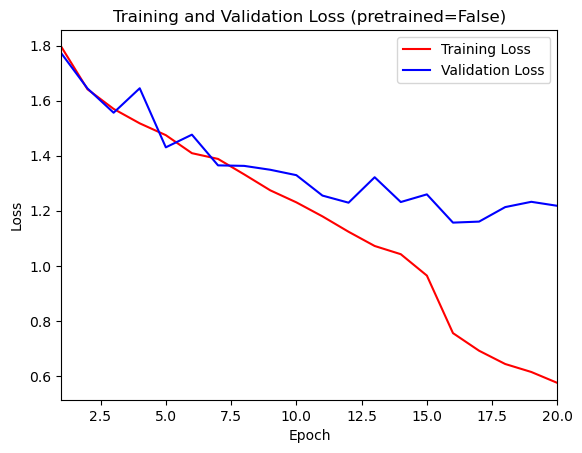

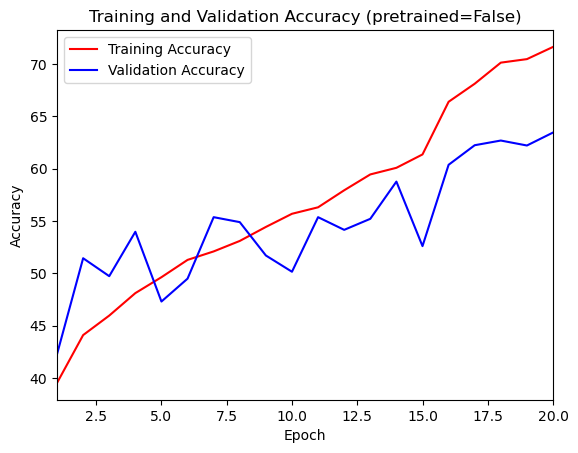

In [31]:
#without pre-trained weights model
plt.title('Training and Validation Loss (pretrained=False)')
plt.plot(epochs, train_losses, label='Training Loss', color='r')
plt.plot(epochs, val_losses, label='Validation Loss', color='b')
plt.xlim(epochs[0], epochs[-1])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.title('Training and Validation Accuracy (pretrained=False)')
plt.plot(epochs, train_accuracies, label='Training Accuracy', color='r')
plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='b')
plt.xlabel('Epoch')
plt.xlim(epochs[0], epochs[-1])
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [32]:
#with pre-trained weights model
file_path = "resnet_metrics2.txt"
epochs = []
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Open the file for reading
with open(file_path, "r") as file:
    # Skip the header line
    file.readline()
    
    # Read each subsequent line
    for line in file:
        # Split the line into values
        epoch, train_loss, val_loss, train_accuracy, val_accuracy = line.strip().split("\t")
        
        # Convert values to appropriate types if necessary
        epoch = int(epoch)
        train_loss = float(train_loss)
        val_loss = float(val_loss)
        train_accuracy = float(train_accuracy)
        val_accuracy = float(val_accuracy)
        
        # Append values to respective lists
        epochs.append(epoch)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

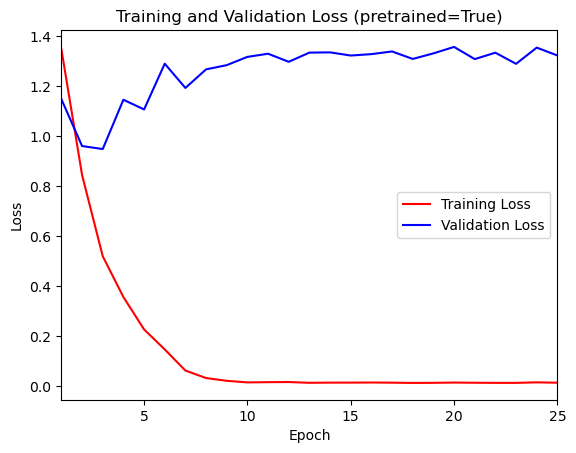

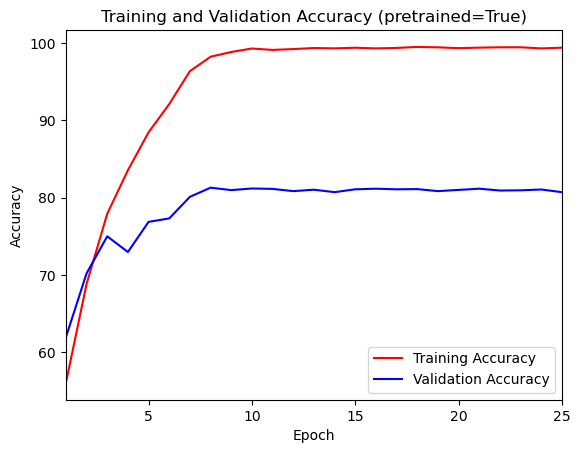

In [33]:
#with pre-trained weights model
plt.title('Training and Validation Loss (pretrained=True)')
plt.plot(epochs, train_losses, label='Training Loss', color='r')
plt.plot(epochs, val_losses, label='Validation Loss', color='b')
plt.xlim(epochs[0], epochs[-1])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.title('Training and Validation Accuracy (pretrained=True)')
plt.plot(epochs, train_accuracies, label='Training Accuracy', color='r')
plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='b')
plt.xlabel('Epoch')
plt.xlim(epochs[0], epochs[-1])
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [22]:
# load saved without pre-trained weights
path_to_model = 'classification_resnet_1.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = timm.create_model('inception_resnet_v2', pretrained=False, num_classes=8)
model.load_state_dict(torch.load(path_to_model))
model.to(device)

cuda


InceptionResnetV2(
  (conv2d_1a): ConvNormAct(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNormAct2d(
      32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): ReLU(inplace=True)
    )
  )
  (conv2d_2a): ConvNormAct(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNormAct2d(
      32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): ReLU(inplace=True)
    )
  )
  (conv2d_2b): ConvNormAct(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNormAct2d(
      64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): ReLU(inplace=True)
    )
  )
  (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3b): ConvNormAct(
    (conv): Conv2d(64, 80, kernel_size=(1, 

In [23]:
#without pre-trained weights model
model.eval()

pred_train_labels = []
train_labels = []

for images, labels in train_loader:
    images = images.to(device)
    with torch.no_grad():
        outputs = model(images)
        _, predicted_labels = torch.max(outputs, 1)
    train_labels.extend(labels.cpu().numpy())  
    pred_train_labels.extend(predicted_labels.cpu().numpy())

pred_val_labels = []
val_labels = []

for images, labels in val_loader:
    images = images.to(device)
    with torch.no_grad():
        outputs = model(images)
        _, predicted_labels = torch.max(outputs, 1)
    val_labels.extend(labels.cpu().numpy())
    pred_val_labels.extend(predicted_labels.cpu().numpy())


pred_train_labels = np.array(pred_train_labels) + 1
train_labels = np.array(train_labels) + 1
pred_val_labels = np.array(pred_val_labels) + 1
val_labels = np.array(val_labels) + 1

/home/infres/pdemoura-23/anaconda3/envs/challenge/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608839953/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


In [24]:
target_names = [
    'Melanoma',
    'Melanocytic nevus',
    'Basal cell carcinoma',
    'Actinic keratosis',
    'Benign keratosis',
    'Dermatofibroma',
    'Vascular lesion',
    'Squamous cell carcinoma'
]

class_weights = [0.7005531, 0.24592265, 0.95261733, 3.64804147, 1.20674543, 13.19375, 12.56547619, 5.04219745]

def weighted_accuracy(y_true, y_pred, class_weights):
    weighted_acc = 0.0
    total_weights = 0.0
    
    for i in range(len(y_true)):
        if y_true[i] == y_pred[i]:
            weighted_acc += class_weights[int(y_true[i] - 1)]
        total_weights += class_weights[int(y_true[i] - 1)]
    
    weighted_acc /= total_weights
    
    return weighted_acc

In [25]:
#without pre-trained weights model
# Generate and print classification reports
report = classification_report(train_labels, pred_train_labels, target_names=target_names)
print("Train Classification Report:")
print(report)

report = classification_report(val_labels, pred_val_labels, target_names=target_names)
print("Validation Classification Report:")
print(report)

# Calculate train weighted accuracy
train_weighted_acc = weighted_accuracy(train_labels, pred_train_labels, class_weights)
print("Train Weighted Accuracy:", train_weighted_acc)

# Calculate validation weighted accuracy
validation_weighted_acc = weighted_accuracy(val_labels, pred_val_labels, class_weights)
print("Validation Weighted Accuracy:", validation_weighted_acc)

Train Classification Report:
                         precision    recall  f1-score   support

               Melanoma       0.65      0.62      0.63      2700
      Melanocytic nevus       0.90      0.74      0.82      7733
   Basal cell carcinoma       0.78      0.84      0.81      1974
      Actinic keratosis       0.49      0.90      0.63       510
       Benign keratosis       0.53      0.68      0.59      1600
         Dermatofibroma       0.60      1.00      0.75       142
        Vascular lesion       0.77      1.00      0.87       158
Squamous cell carcinoma       0.58      0.95      0.72       381

               accuracy                           0.74     15198
              macro avg       0.66      0.84      0.73     15198
           weighted avg       0.78      0.74      0.75     15198

Validation Classification Report:
                         precision    recall  f1-score   support

               Melanoma       0.52      0.49      0.51       691
      Melanocytic nevus

In [26]:
# load saved model with pre-trained weights
path_to_model = 'classification_resnet_2.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = timm.create_model('inception_resnet_v2', pretrained=False, num_classes=8)
model.load_state_dict(torch.load(path_to_model))
model.to(device)

cuda


InceptionResnetV2(
  (conv2d_1a): ConvNormAct(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNormAct2d(
      32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): ReLU(inplace=True)
    )
  )
  (conv2d_2a): ConvNormAct(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNormAct2d(
      32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): ReLU(inplace=True)
    )
  )
  (conv2d_2b): ConvNormAct(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNormAct2d(
      64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): ReLU(inplace=True)
    )
  )
  (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3b): ConvNormAct(
    (conv): Conv2d(64, 80, kernel_size=(1, 

In [27]:
#with pre-trained weights model
model.eval()

pred_train_labels = []
train_labels = []

for images, labels in train_loader:
    images = images.to(device)
    with torch.no_grad():
        outputs = model(images)
        _, predicted_labels = torch.max(outputs, 1)
    train_labels.extend(labels.cpu().numpy())  
    pred_train_labels.extend(predicted_labels.cpu().numpy())

pred_val_labels = []
val_labels = []

for images, labels in val_loader:
    images = images.to(device)
    with torch.no_grad():
        outputs = model(images)
        _, predicted_labels = torch.max(outputs, 1)
    val_labels.extend(labels.cpu().numpy())
    pred_val_labels.extend(predicted_labels.cpu().numpy())


pred_train_labels = np.array(pred_train_labels) + 1
train_labels = np.array(train_labels) + 1
pred_val_labels = np.array(pred_val_labels) + 1
val_labels = np.array(val_labels) + 1

In [28]:
#with pre-trained weights model
# Generate and print classification reports
report = classification_report(train_labels, pred_train_labels, target_names=target_names)
print("Train Classification Report:")
print(report)

report = classification_report(val_labels, pred_val_labels, target_names=target_names)
print("Validation Classification Report:")
print(report)

# Calculate train weighted accuracy
train_weighted_acc = weighted_accuracy(train_labels, pred_train_labels, class_weights)
print("Train Weighted Accuracy:", train_weighted_acc)

# Calculate validation weighted accuracy
validation_weighted_acc = weighted_accuracy(val_labels, pred_val_labels, class_weights)
print("Validation Weighted Accuracy:", validation_weighted_acc)

Train Classification Report:
                         precision    recall  f1-score   support

               Melanoma       1.00      1.00      1.00      2700
      Melanocytic nevus       1.00      0.99      1.00      7733
   Basal cell carcinoma       0.99      1.00      0.99      1974
      Actinic keratosis       1.00      1.00      1.00       510
       Benign keratosis       0.99      1.00      1.00      1600
         Dermatofibroma       1.00      1.00      1.00       142
        Vascular lesion       0.99      1.00      0.99       158
Squamous cell carcinoma       1.00      1.00      1.00       381

               accuracy                           1.00     15198
              macro avg       1.00      1.00      1.00     15198
           weighted avg       1.00      1.00      1.00     15198

Validation Classification Report:
                         precision    recall  f1-score   support

               Melanoma       0.74      0.66      0.69       691
      Melanocytic nevus

## Classification of the images in Test set

In [29]:
# load saved model
path_to_model = 'classification_resnet_2.pth' ##to be changed according to desired saved model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = timm.create_model('inception_resnet_v2', pretrained=False, num_classes=8)
model.load_state_dict(torch.load(path_to_model))
model.to(device)

cuda


InceptionResnetV2(
  (conv2d_1a): ConvNormAct(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNormAct2d(
      32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): ReLU(inplace=True)
    )
  )
  (conv2d_2a): ConvNormAct(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNormAct2d(
      32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): ReLU(inplace=True)
    )
  )
  (conv2d_2b): ConvNormAct(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNormAct2d(
      64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): ReLU(inplace=True)
    )
  )
  (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3b): ConvNormAct(
    (conv): Conv2d(64, 80, kernel_size=(1, 

In [33]:
# Generate test results csv
file_path = 'metadata/metadataTest.csv'
metadata_test = pd.read_csv(file_path)
#print(metadata_test.head())

test_dir = 'Test'
test_data = CustomDataset(test_dir, metadata_test, train=False, num_channels=3, transform=img_transform)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=os.cpu_count())

# Set the model to evaluation mode
model.eval()

# Make predictions for the test data
predictions = []
for images in test_dataloader:
    images = images.to(device)
    with torch.no_grad():
        outputs = model(images)
        _, predicted_labels = torch.max(outputs, 1)
    predictions.extend(predicted_labels.cpu().numpy())

predictions = np.array(predictions) + 1

# Convert the predicted labels to a pandas DataFrame
test_results = pd.DataFrame({'ID': metadata_test['ID'], 'CLASS': predictions})

# Save the DataFrame to a CSV file
test_results.to_csv('test_results_resnet_2.csv', index=False) ##to be changed according to desired saved model